In [1]:
# !pip install segment-anything
# !pip install openai-clip

In [49]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches

from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from scipy.linalg import sqrtm
from PIL import Image
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def get_SAM_masks(image):
    mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="./sam_vit_h_4b8939.pth").to('cuda'))
    masks = mask_generator.generate(image)
    return masks

In [4]:
def get_CLIP_features(cropped_imgs, image, search_text):
    model, preprocess = clip.load("ViT-B/32", device=device)
    preprocessed_images = [preprocess(image).to(device) for image in cropped_imgs]
    tokenized_text = clip.tokenize(search_text).to(device)
    
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features, image_features

In [5]:
@torch.no_grad()
def get_probs(images_list: list[Image.Image], search_text: list[str], image: Image.Image) -> int:
    text_features, image_features = get_CLIP_features(images_list, image, search_text)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [6]:
def overlay_masks(image, masks):
    overlay = image.copy()
    colors = plt.cm.get_cmap("tab10", len(masks))  # Generate distinct colors for masks
    
    for i, mask in enumerate(masks):
        segmentation = mask["segmentation"]
        color = (np.array(colors(i)[:3]) * 255).astype(int)  # Convert color to RGB scale
        mask_layer = np.zeros_like(image, dtype=np.uint8)
        
        for c in range(3):  # Apply the color to all channels
            mask_layer[:, :, c] = segmentation * color[c]
        
        overlay = cv2.addWeighted(overlay, 1.0, mask_layer, 0.5, 0)  # Blend the mask with the image
    
    return overlay

In [7]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [8]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [9]:
# Cut out all masks
def cut_all_masks(image_path, mask):
    image = Image.open(image_path)
    cropped_boxes = []
    
    for mask in masks:
        cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))
    return cropped_boxes

In [10]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

In [11]:
def get_combined_mask(masks, original_image, indices):
    # Combine all binary masks into one
    combined_mask = np.zeros((original_image.size[1], original_image.size[0]), dtype=np.uint8)
    segmentation_masks = []
    for seg_idx in indices:
        mask_array = masks[seg_idx]["segmentation"]
        mask_resized = np.array(
            Image.fromarray(mask_array).resize(original_image.size, resample=Image.NEAREST)
        )
        combined_mask = np.logical_or(combined_mask, mask_resized).astype(np.uint8)
    return combined_mask

In [12]:
def get_masked_img(original_image, combined_mask):

    overlay_color = (255, 0, 0, 100)  # Red with transparency
    overlay_image = Image.new('RGBA', original_image.size, (0, 0, 0, 0))
    overlay_pixels = overlay_image.load()
    
    # Apply the overlay using the binary mask
    for y in range(combined_mask.shape[0]):
        for x in range(combined_mask.shape[1]):
            if combined_mask[y, x] == 1:
                overlay_pixels[x, y] = overlay_color
    
    # Combine overlay with the original image
    result_image = Image.alpha_composite(original_image, overlay_image)
    return result_image

In [13]:
def get_binary_mask(original_image, masks, indices):
    binary_mask = np.zeros((original_image.size[1], original_image.size[0]), dtype=np.uint8)

    # Combine all binary masks into one
    for seg_idx in indices:
        mask_array = masks[seg_idx]["segmentation"]  # Get the segmentation binary array
        # Resize the mask to match the original image size
        mask_resized = np.array(
            Image.fromarray(mask_array).resize(original_image.size, resample=Image.NEAREST)
        )
        # Combine masks using a logical OR operation
        binary_mask = np.logical_or(binary_mask, mask_resized).astype(np.uint8)
        
    return binary_mask

In [14]:
def get_bbox(combined_mask):
    coords = np.column_stack(np.where(combined_mask > 0))
    if coords.size > 0:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        bbox = (x_min, y_min, x_max, y_max)
    else:
        bbox = None  # No segmentation found

    return bbox

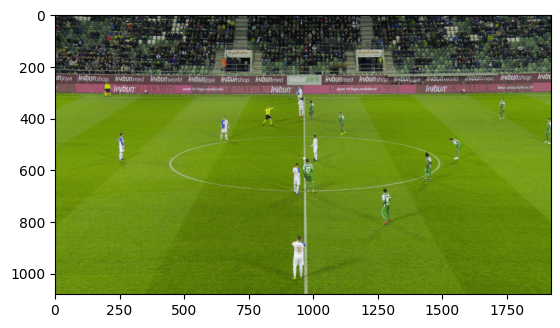

In [15]:
image_path = "./SNMOT-060_1.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [16]:
masks = get_SAM_masks(image)

C:\Users\syeda\miniconda3\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


C:\Users\syeda\AppData\Local\Temp\ipykernel_11848\2747254891.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(masks))  # Generate distinct colors for masks


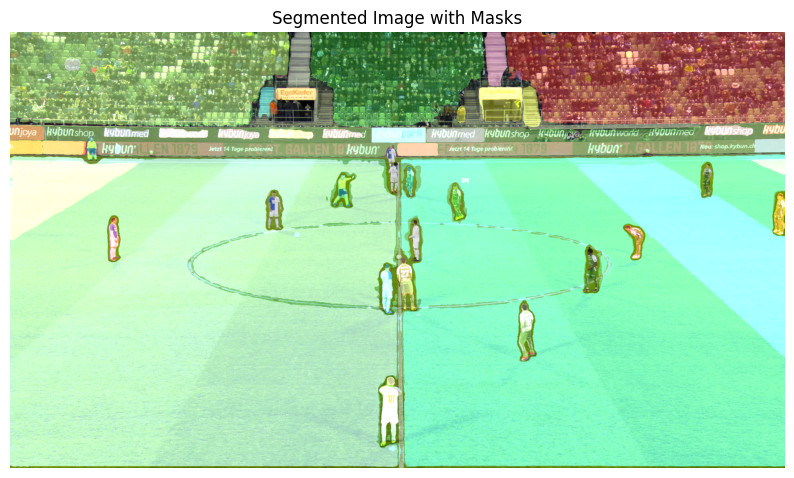

In [17]:
overlayed_image = overlay_masks(np.array(image), masks)

plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis("off")
plt.title("Segmented Image with Masks")
plt.show()

In [18]:
cropped_boxes = cut_all_masks(image_path, masks)

C:\Users\syeda\miniconda3\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


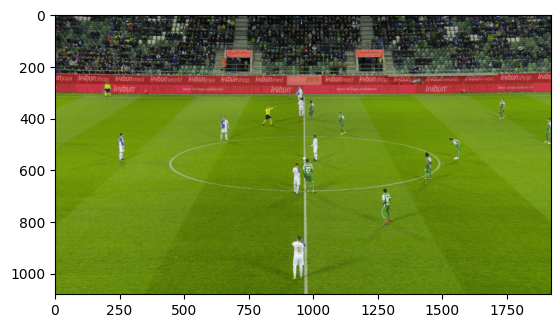

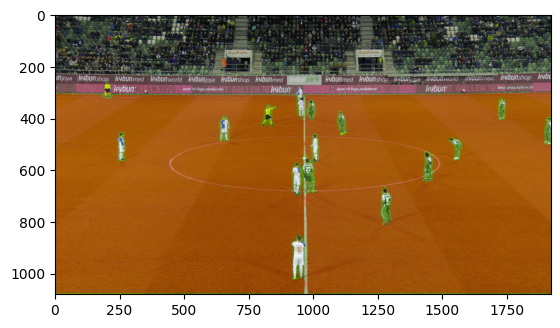

In [19]:
original_image = Image.open(image_path)
original_image = original_image.convert("RGBA") 

ad_scores = get_probs(cropped_boxes, ["advert", 'advertisement', 'board', 'ad-banner'], image) 
field_scores = get_probs(cropped_boxes, ['soccer field'], image)
ad_indices = get_indices_of_values_above_threshold(ad_scores, 0.05)
field_indices = get_indices_of_values_above_threshold(field_scores, 0.05)

ad_combined_mask = get_combined_mask(masks, original_image, ad_indices)
field_combined_mask = get_combined_mask(masks, original_image, field_indices)

ad_result = get_masked_img(original_image, ad_combined_mask)
field_result = get_masked_img(original_image, field_combined_mask)

plt.imshow(ad_result)
plt.show()

plt.imshow(field_result)
plt.show()

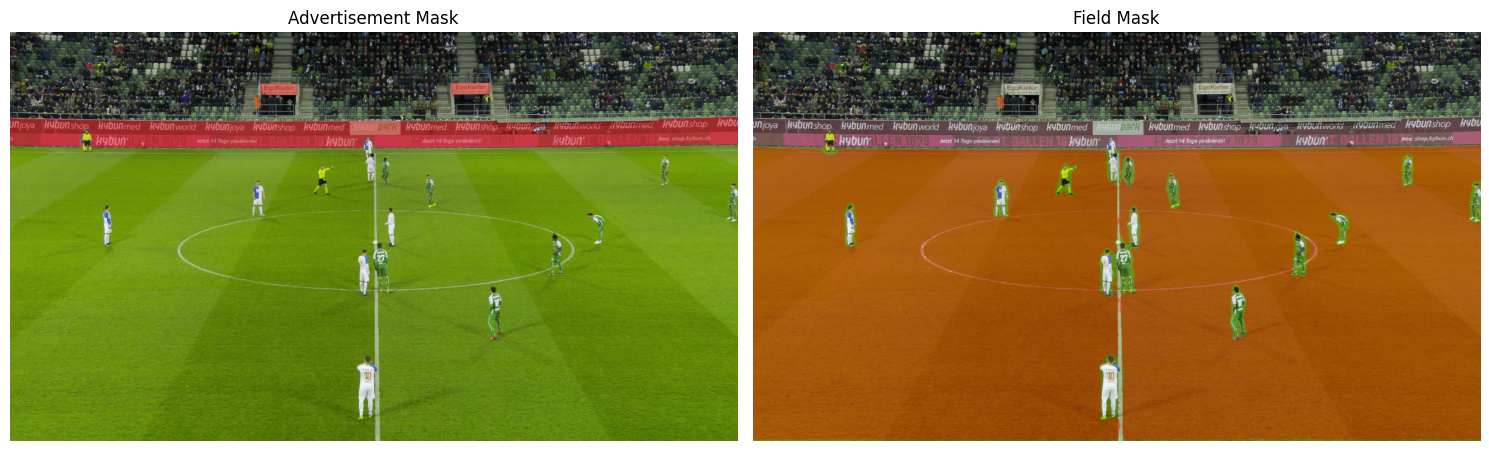

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

axes[0].imshow(ad_result)
axes[0].axis('off')  # Hide axes
axes[0].set_title("Advertisement Mask")

axes[1].imshow(field_result)
axes[1].axis('off')  # Hide axes
axes[1].set_title("Field Mask")

plt.tight_layout()
plt.show()

In [21]:
ad_binary_mask = get_binary_mask(original_image, masks, ad_indices)
field_binary_mask = get_binary_mask(original_image, masks, field_indices)

# Convert the binary mask into a PIL image and multiply by 255 for visibility
ad_binary_mask_image = Image.fromarray((ad_binary_mask * 255).astype(np.uint8))  
field_binary_mask_image = Image.fromarray((field_binary_mask * 255).astype(np.uint8))  

ad_binary_mask_image.save("ad_binary_mask.png")
field_binary_mask_image.save("field_binary_mask.png")

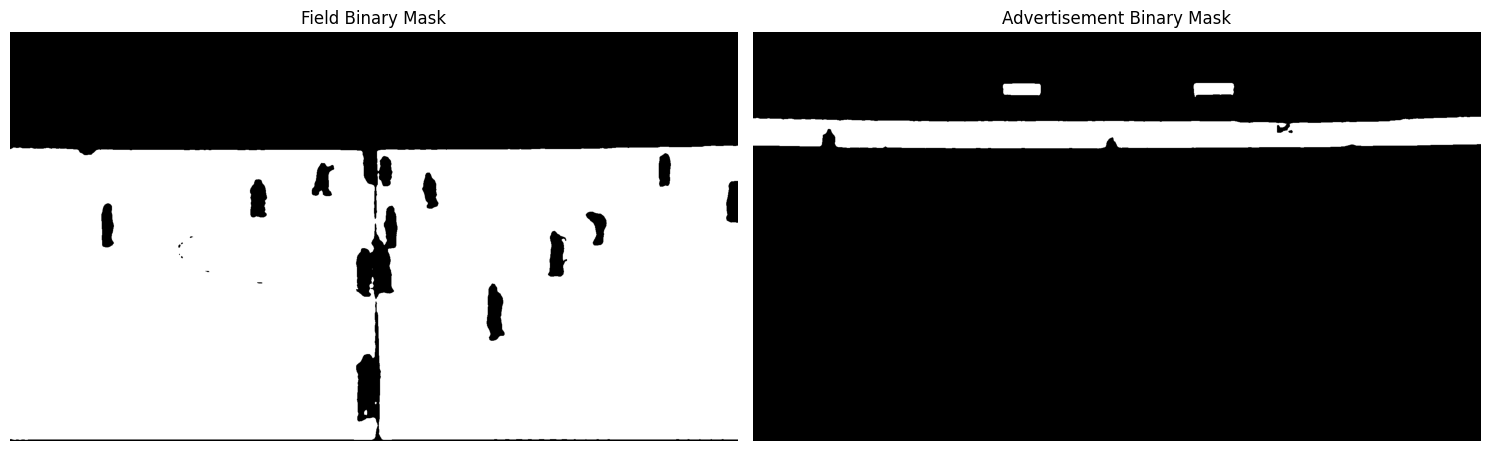

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

axes[0].imshow(field_binary_mask_image, cmap='gray')
axes[0].axis('off')  # Hide axes
axes[0].set_title("Field Binary Mask")

axes[1].imshow(ad_binary_mask_image, cmap='gray')
axes[1].axis('off')  # Hide axes
axes[1].set_title("Advertisement Binary Mask")

plt.tight_layout()
plt.show()

# Extarcting Bounding Boxes of the Segmentation Masks

In [23]:
field_bbox = get_bbox(field_combined_mask)  
ad_bbox = get_bbox(ad_combined_mask)  

Bounding Box: (0, 302, 1919, 1076)


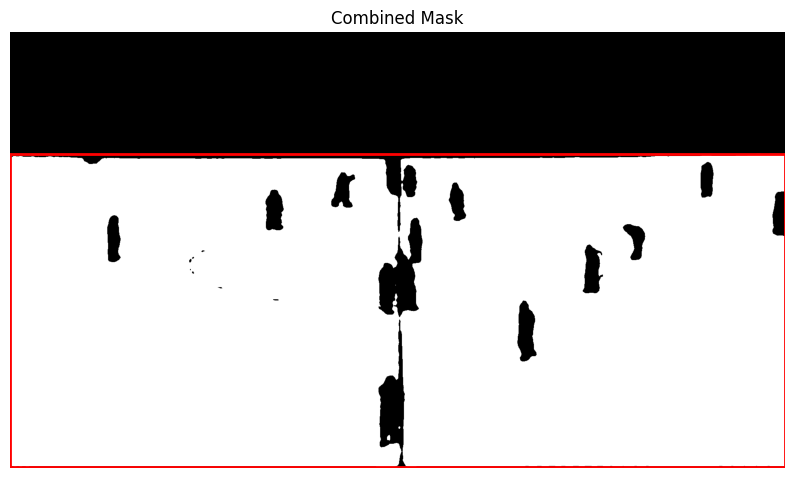

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(field_combined_mask, cmap="gray")
plt.title("Combined Mask")
plt.axis("off")

if field_bbox:
    print(f"Bounding Box: {field_bbox}")
    rect = patches.Rectangle((field_bbox[0], field_bbox[1]), field_bbox[2] - field_bbox[0], field_bbox[3] - field_bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
else:
    print("No segmentation detected.")

plt.show()

Field Bounding Box: (0, 302, 1919, 1076)
Ad Bounding Box: (0, 137, 1919, 309)


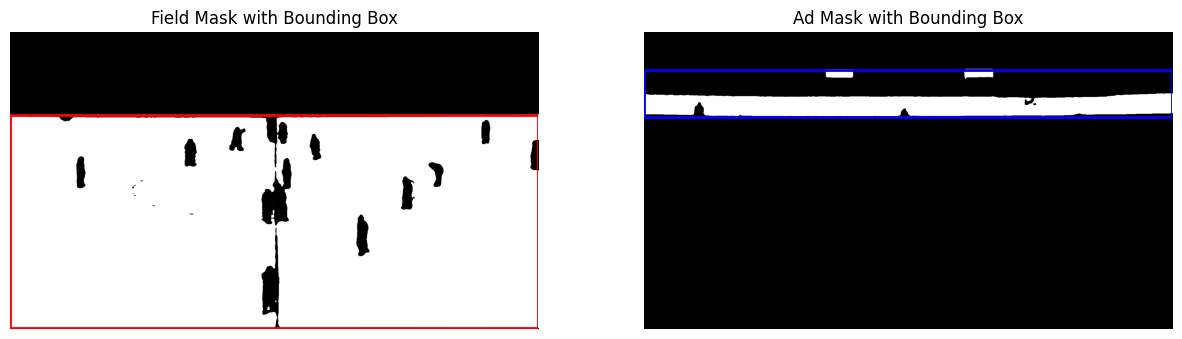

In [25]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(field_combined_mask, cmap="gray")
plt.title("Field Mask with Bounding Box")
plt.axis("off")

if field_bbox:
    print(f"Field Bounding Box: {field_bbox}")
    field_rect = patches.Rectangle((field_bbox[0], field_bbox[1]), field_bbox[2] - field_bbox[0], field_bbox[3] - field_bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(field_rect)
else:
    print("No field segmentation detected.")

plt.subplot(1, 2, 2)
plt.imshow(ad_combined_mask, cmap="gray")
plt.title("Ad Mask with Bounding Box")
plt.axis("off")

if ad_bbox:
    print(f"Ad Bounding Box: {ad_bbox}")
    ad_rect = patches.Rectangle((ad_bbox[0], ad_bbox[1]), ad_bbox[2] - ad_bbox[0], ad_bbox[3] - ad_bbox[1], linewidth=2, edgecolor='b', facecolor='none')
    plt.gca().add_patch(ad_rect)
else:
    print("No advertisement segmentation detected.")

plt.show()

# Placing Ad on Soccer Field using Homography

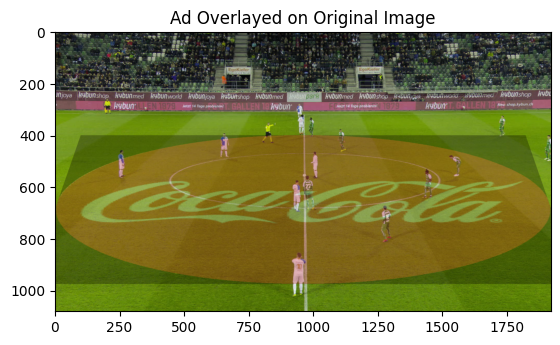

In [26]:
field_img = cv2.imread(image_path)
ad_img = cv2.imread("./coke.drawio.png")

x1,y1,x2,y2 = field_bbox

# Define four points of the ad placement (on the soccer pitch)
src_pts = np.array([[0, 0], [ad_img.shape[1], 0], [ad_img.shape[1], ad_img.shape[0]], [0, ad_img.shape[0]]], dtype="float32")
dst_pts = np.array([[x1+100, y1+100],                # Top-left corner of the bounding box
                    [x2-100, y1+100],                # Top-right corner of the bounding box
                    [x2+100, y2-100],                # Bottom-right corner of the bounding box
                    [x1-100, y2-100]],               # Bottom-left corner of the bounding box
                    dtype="float32")

h_matrix, _ = cv2.findHomography(src_pts, dst_pts)

# Warp ad image onto soccer pitch
warped_ad = cv2.warpPerspective(ad_img, h_matrix, (field_img.shape[1], field_img.shape[0]))
mask = cv2.warpPerspective(np.ones_like(ad_img[:, :, 0]), h_matrix, (field_img.shape[1], field_img.shape[0]))

# Blend warped ad with the field image
field_img[mask > 0] = cv2.addWeighted(field_img[mask > 0], 0.7, warped_ad[mask > 0], 0.25, 0)

plt.imshow(cv2.cvtColor(field_img, cv2.COLOR_BGRA2RGBA))
plt.title('Ad Overlayed on Original Image')
plt.savefig('image_1.png', dpi=300, bbox_inches='tight')
plt.show()

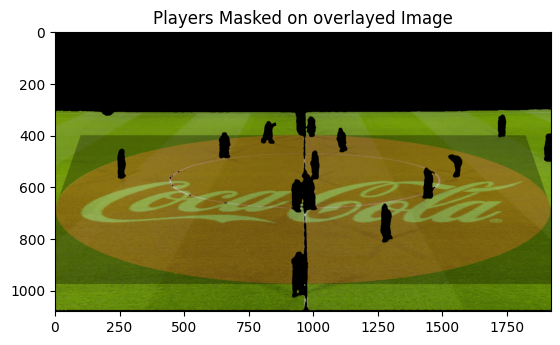

In [27]:
original_image = cv2.imread('./SNMOT-060_1.jpg')

binary_mask_3d = np.expand_dims(((field_binary_mask*255)), axis=-1)  # Shape: (H, W, 1)
binary_mask_3d = np.repeat(binary_mask_3d, 3, axis=-1)  # Shape: (H, W, 3)

masked_image = field_img & binary_mask_3d

plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title('Players Masked on overlayed Image')
plt.savefig('image_2.png', dpi=300, bbox_inches='tight')
plt.show()

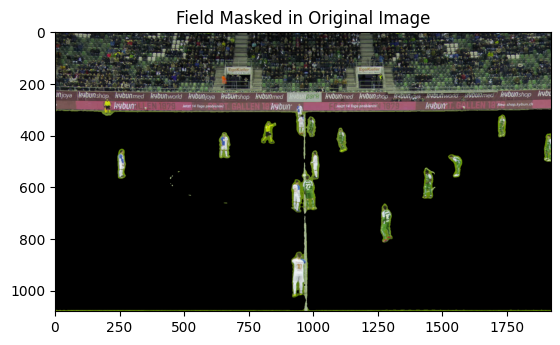

In [28]:
binary_mask_3d = np.expand_dims((255 - (field_binary_mask*255)), axis=-1)  # Shape: (H, W, 1)
binary_mask_3d = np.repeat(binary_mask_3d, 3, axis=-1)  # Shape: (H, W, 3)

mask2 = original_image & binary_mask_3d
plt.imshow(cv2.cvtColor(mask2, cv2.COLOR_BGR2RGB))
plt.title('Field Masked in Original Image')
plt.savefig('image_3.png', dpi=300, bbox_inches='tight')
plt.show()

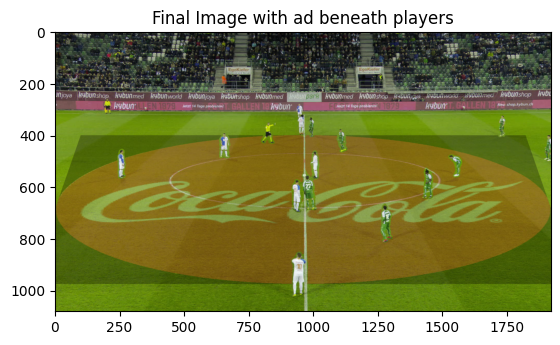

In [29]:
final_img = cv2.cvtColor(masked_image + mask2, cv2.COLOR_BGR2RGB)
plt.imshow(final_img)
plt.title('Final Image with ad beneath players')
plt.savefig('image_4.png', dpi=300, bbox_inches='tight')
plt.show()

# Placing Ad on Soccer Field Pitch Side Banner using Homography

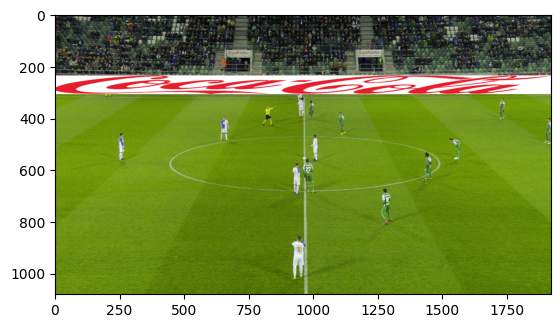

In [30]:
field_img = cv2.imread(image_path)
ad_img = cv2.imread("./coke_ad.png")

x1,y1,x2,y2 = ad_bbox

src_pts = np.array([[0, 0], [ad_img.shape[1], 0], [ad_img.shape[1], ad_img.shape[0]], [0, ad_img.shape[0]]], dtype="float32")
dst_pts = np.array([[x1, y1+100],                # Top-left corner of the bounding box
                    [x2, y1+100],                # Top-right corner of the bounding box
                    [x2, y2],                # Bottom-right corner of the bounding box
                    [x1, y2]],               # Bottom-left corner of the bounding box
                    dtype="float32")

h_matrix, _ = cv2.findHomography(src_pts, dst_pts)

warped_ad = cv2.warpPerspective(ad_img, h_matrix, (field_img.shape[1], field_img.shape[0]))
mask = cv2.warpPerspective(np.ones_like(ad_img[:, :, 0]), h_matrix, (field_img.shape[1], field_img.shape[0]))

field_img[mask > 0] = cv2.addWeighted(field_img[mask > 0], 0, warped_ad[mask > 0], 1, 0)

plt.imshow(cv2.cvtColor(field_img, cv2.COLOR_BGRA2RGBA))
plt.savefig('fake_img.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
def get_rand_bbox(bbox):
    x_min, y_min, x_max, y_max = bbox
    random_x = random.randint(x_min, x_max)
    random_y = random.randint(y_min, y_max)
    
    random_coordinates = (random_x, random_y)
    x,y = random_coordinates
    w,h = x+250, y+250
    bbox = (x,y,w,h)
    return bbox

In [32]:
def overlay_ad_with_affine(original_image, ad_image_path, bbox):
    ad_img = cv2.imread(ad_image_path)
    x_min, y_min, x_max, y_max = bbox
    
    src_pts = np.array([[0, 0], [ad_img.shape[1], 0], [0, ad_img.shape[0]]], dtype="float32")
    
    # dst_pts = np.array([[x_min+200, y_min+200], [x_max+200, y_min], [x_min + 500, y_max]], dtype="float32")
    dst_pts = np.array([[x_min+100, y_min+200], [x_max+150, y_min-50], [x_min + 400, y_max-10]], dtype="float32")

    affine_matrix = cv2.getAffineTransform(src_pts, dst_pts)
    warped_ad = cv2.warpAffine(ad_img, affine_matrix, (original_image.shape[1], original_image.shape[0]))
    
    # Create a mask for blending
    mask = cv2.warpAffine(np.ones_like(ad_img[:, :, 0]), affine_matrix, (original_image.shape[1], original_image.shape[0]))
    
    # Blend the warped ad with the original image
    result_img = original_image.copy()
    result_img[mask > 0] = cv2.addWeighted(original_image[mask > 0], 0.7, warped_ad[mask > 0], 0.3, 0)
    
    return result_img

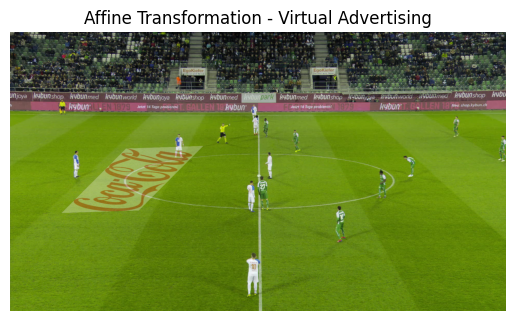

In [48]:
original_image = cv2.imread(image_path)
x,y,w,h = get_rand_bbox(field_bbox)
bbox = (100, 500, 300, 700)#(x,y,w,h)

# Path to the advertisement image
ad_image_path = "./coke_ad.png"

# Overlay the advertisement using affine transformation
result_image = overlay_ad_with_affine(original_image, ad_image_path, bbox)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Affine Transformation - Virtual Advertising")
plt.show()

In [ ]:
# !pip install diffusers
# !pip install accelerate

# Inpaininting Model for Ad Generation and Placement

In [40]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch

pipe = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16, variant="fp16").to("cuda")

# img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
# mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

# image = load_image(img_url).resize((1024, 1024))
# mask_image = load_image(mask_url).resize((1024, 1024))

img_path = './SNMOT-060_1.jpg'
mask_path = './binary_mask.png'

image = Image.open(img_path).resize((1024, 1024))
mask_image= Image.open(mask_path).resize((1024, 1024))

mask_image = Image.fromarray(np.array(mask_image) * 255)

prompt = "coca cola logo"
generator = torch.Generator(device=device).manual_seed(0)

image = pipe(
  prompt=prompt,
  image=image,
  mask_image=mask_image,
  guidance_scale=8.0,
  num_inference_steps=20,  # steps between 15 and 30 work well for us
  strength=0.99,  # make sure to use `strength` below 1.0
  generator=generator,
).images[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.04it/s]


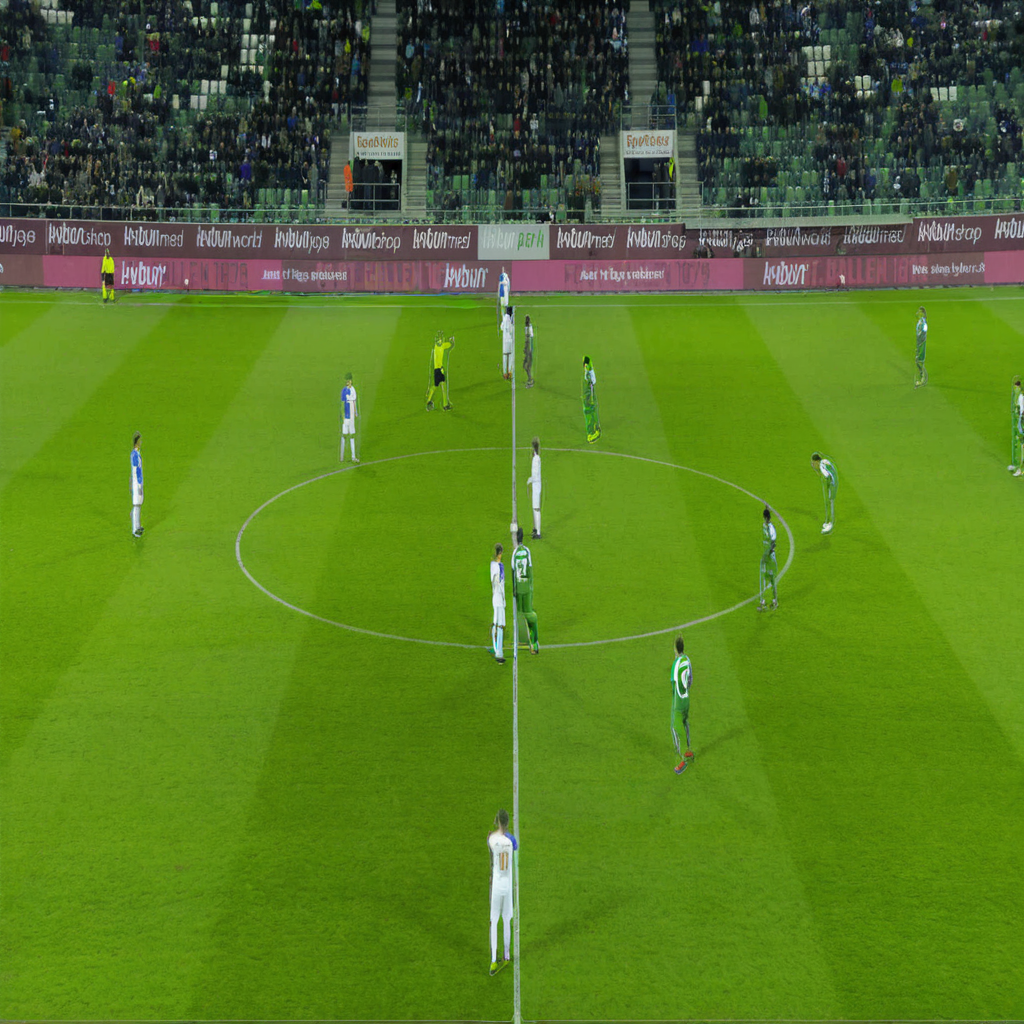

In [43]:
image.save('generated_image.png')
image

In [20]:
# from diffusers import StableDiffusionInpaintPipeline

# pipe = StableDiffusionInpaintPipeline.from_pretrained(
#     "stabilityai/stable-diffusion-2-inpainting",
#     torch_dtype=torch.float16,
# )
# pipe.to("cuda")
# prompt = "a nike advertisement on football pitch banner"
# #image and mask_image should be PIL images.
# img_path = './SNMOT-060_1.jpg'
# mask_path = './binary_mask.png'

# image = Image.open(img_path).resize((1024, 1024))
# mask_image= Image.open(mask_path).resize((1024, 1024))

# #The mask structure is white for inpainting and black for keeping as is
# image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
# # image.save("./yellow_cat_on_park_bench.png")

# Calculating FID

In [50]:
def calculate_fid(real_features, gen_features):
    mu_r = np.mean(real_features, axis=0)
    sigma_r = np.cov(real_features, rowvar=False)
    
    mu_g = np.mean(gen_features, axis=0)
    sigma_g = np.cov(gen_features, rowvar=False)

    diff = mu_r - mu_g
    mean_diff = np.dot(diff, diff)

    cov_mean, _ = sqrtm(np.dot(sigma_r, sigma_g), disp=False)

    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
 
    fid = mean_diff + np.trace(sigma_r + sigma_g - 2 * cov_mean)
    return fid

In [51]:
def get_inception_model():
    inception = model = models.inception_v3(pretrained=True, transform_input=False)
    inception.eval() 
    return inception

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    image = Image.open(image_path).convert('RGB') 
    image = transform(image).unsqueeze(0)  
    return image

def extract_inception_features(model, image_tensor):
    with torch.no_grad():
        features = model(image_tensor)
    return features.detach().numpy()

In [52]:
def get_fid(real_image_path, fake_image_path):
    inception_model = get_inception_model()
    real_tensor = preprocess_image(real_image_path)
    real_features = extract_inception_features(inception_model, real_tensor)
    
    fake_tensor = preprocess_image(fake_image_path)
    fake_features = extract_inception_features(inception_model, fake_tensor)

    real_features = real_features.reshape(4, 250)
    fake_features = fake_features.reshape(4, 250)
    return calculate_fid(real_features, fake_features)

In [54]:
get_fid('./SNMOT-060_1.jpg', './fake_img.png')

C:\Users\syeda\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\syeda\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


282.6134552925936

In [55]:
get_fid('./SNMOT-060_1.jpg', './generated_image.png')

C:\Users\syeda\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\syeda\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


20.234561884460632

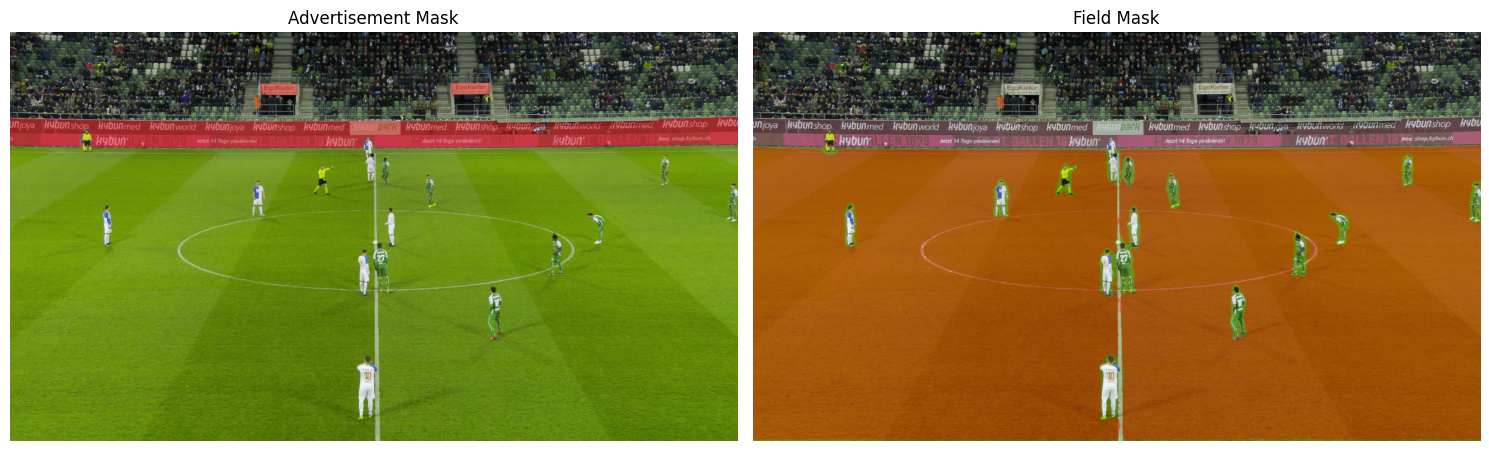

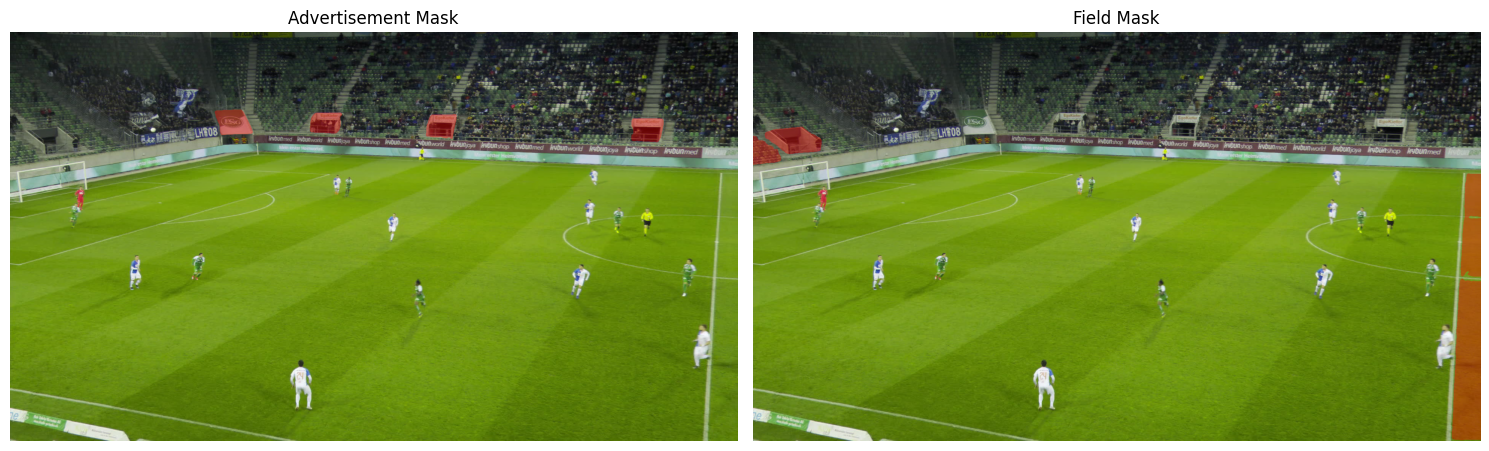

In [57]:
images_path = ['./SNMOT-060_1.jpg', './SNMOT-060_252.jpg']

for ip in images_path:
    image = cv2.imread(ip)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = get_SAM_masks(image)
    cropped_boxes = cut_all_masks(image_path, masks)
    
    ad_scores = get_probs(cropped_boxes, ["advert", 'advertisement', 'board', 'ad-banner'], image) 
    field_scores = get_probs(cropped_boxes, ['soccer field'], image)
    ad_indices = get_indices_of_values_above_threshold(ad_scores, 0.05)
    field_indices = get_indices_of_values_above_threshold(field_scores, 0.05)

    original_image = Image.open(ip)
    original_image = original_image.convert("RGBA") 
    
    ad_combined_mask = get_combined_mask(masks, original_image, ad_indices)
    field_combined_mask = get_combined_mask(masks, original_image, field_indices)
    
    ad_result = get_masked_img(original_image, ad_combined_mask)
    field_result = get_masked_img(original_image, field_combined_mask)

    field_bbox = get_bbox(field_combined_mask)  
    ad_bbox = get_bbox(ad_combined_mask)  

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

    axes[0].imshow(ad_result)
    axes[0].axis('off')  # Hide axes
    axes[0].set_title("Advertisement Mask")
    
    axes[1].imshow(field_result)
    axes[1].axis('off')  # Hide axes
    axes[1].set_title("Field Mask")
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Using reference image to add object in generated image
import torch
from diffusers import StableDiffusionGLIGENTextImagePipeline
from diffusers.utils import load_image

pipe = StableDiffusionGLIGENTextImagePipeline.from_pretrained("anhnct/Gligen_Inpainting_Text_Image", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

input_image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/gligen/livingroom_modern.png"
)

prompt = "a backpack"
boxes = [[0.2676, 0.4088, 0.4773, 0.7183]]
phrases = None
gligen_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/gligen/backpack.jpeg"
)

images = pipe(
    prompt=prompt,
    gligen_phrases=phrases,
    gligen_inpaint_image=input_image,
    gligen_images=[gligen_image],
    gligen_boxes=boxes,
    gligen_scheduled_sampling_beta=1,
    output_type="pil",
    num_inference_steps=50,
).images

images[0].save("./gligen-inpainting-text-image-box.jpg")


C:\Users\syeda\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\syeda\.cache\huggingface\hub\models--anhnct--Gligen_Inpainting_Text_Image. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Fetching 21 files:   5%|███                                                             | 1/21 [00:01<00:27